# Data Prepration

In [1]:
from prepross import *
import numpy as np
import os
import dataloader
from dataloader import Vocab
pd.options.display.max_rows = 100
from embedding import Doc2VecEmbedding
import pickle
import numpy as np
import time

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mehrazin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mehrazin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
class Parse():
    def __init__(self):
        self.test_mode = True
        self.load_vocab = True
        self.exp_id = 3
        self.load_model = False
        self.prepare_data = True
        self.save_every = 10
        self.dump_loss = True
        self.num_epochs = 10
        self.batch_size = 4
arg = Parse()

In [3]:
config = Config(arg)

In [4]:
config.exp_dir

'/home/mehrazin/Documents/DAV_project/Repository/Music-Recommendation/Dumped/3'

In [5]:
config.Dataset_dir

'/home/mehrazin/Documents/DAV_project/Repository/Music-Recommendation/Dataset/Test/1k-item/Datasets'

In [6]:
config.device

device(type='cpu')

For each dataset, we have to have a directory with the name of that dataset, ex: '10k_item', and it has to have two different directories 'Datasets' and 'Doc2Vec'. So, the config.Dataset_dir would be for example '~/Music-Recommendation/Dataset/Test/10k-item/Datasets'. After, completing the embedding part, 'Datasets' directory should contain 'df_doc2vec.csv' and 'doc2vec_vectors.pkl'.
merge_val_item takes config as an argument and produces users.csv, items.csv, Dataset.csv. We should put them in the Datasets folder.
Vocab(config) build a vocabulary and dumps it as 'vocab.pkl'. We should put it in the 'Datasets' folder.
save_data(config) prepares data for training, validation, and testing.
After that, we can run the main.py to train and save the model.

In [ ]:
merge_val_item(config)

In [ ]:
vocab = Vocab(config)

In [ ]:
save_data(config)

In [7]:
# df = Data_handler(config, pass_col = ['lyrics'])
# df.data = df.get_masked_data(users = df.users[:3], fracs = [0.1,0.2,0.1])
# df.data = create_session(df.data, config)
# df.data = clean_data(df.data, config)
# df.data = cut_sessions(df.data, config)
# config.clean_mode = ['rm_small_sub_session']
# df.data = clean_data(df.data, config)
# df.data

# Loss

In [8]:
path = os.path.join(config.exp_dir,'loss.pkl')
with open(path, 'rb') as f:
    loss = pickle.load(f)

In [9]:
def Average(lst):
    return sum(lst) / len(lst)
train_loss = [Average(batch_loss[0]) for batch_loss in loss]
valid_loss = [Average(batch_loss[1]) for batch_loss in loss]
test_loss = [Average(batch_loss[2]) for batch_loss in loss]

In [12]:
train_loss

[0.25847447369136844]

In [10]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(train, valid, test):
    plt.figure()
    epochs = range(1,len(train) + 1)
    plt.plot(epochs, train, 'g', label='Training loss')
    plt.plot(epochs, valid, 'b', label='Validation loss')
    plt.plot(epochs, test, 'r', label='Test loss')
    plt.grid(True)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

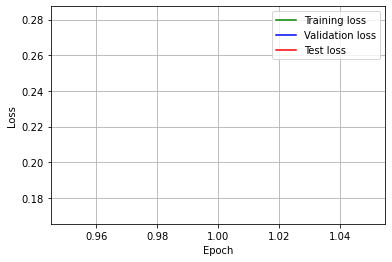

In [11]:
showPlot(train_loss, valid_loss, test_loss)

# Model Prepration

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from dataloader import Music_data, create_data_loader
import torch.optim as optim
import torch.nn.functional as F
import Model
import random
from Model import create_embeding, Seq2Seq, Encoder, Decoder

In [9]:
seed = 0
"""Set seed"""
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

In [19]:
config.num_epochs = 1000
config.batch_size = 50
config.learning_rate = 0.001

In [20]:
embedding, dim, _ = Model.create_embeding(config)
train_iterator = create_data_loader(config, 'train', shuffle = True)
test_iterator = create_data_loader(config, 'test', shuffle = True)
valid_iterator = create_data_loader(config, 'valid', shuffle = True)
itr = iter(train_iterator)
# df = Music_data(config, 'train')

In [21]:
enc = Encoder(config).to(config.device)
dec = Decoder(config).to(config.device)
model = Seq2Seq(config, enc, dec).to(config.device)

In [22]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
pad_idx = config.pad_index
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [23]:
# Tensorboard to get nice loss plot
writer = SummaryWriter(f"runs/loss_plot")
step = 0

In [24]:
# Overfit a single batch
batch = next(iter(train_iterator))

In [25]:
# u, i, o = batch

In [26]:
tic = time.perf_counter()
for epoch in range(config.num_epochs):
#     for batch_idx, batch in enumerate(train_iterator):
    users, source, target = batch
    users = users.to(config.device)
    source = (source[0].to(config.device), source[1].to(config.device))
    target = (target[0].to(config.device), target[1].to(config.device))
    output = model(config, users, source, target)

    output = output[1:].reshape(-1, output.shape[2])
    target = target[0][1:].reshape(-1)

    optimizer.zero_grad()
    loss = criterion(output, target)

    # Back prop
    loss.backward()
    if epoch%20 == 0:
        print(loss.item())

    # Clip to avoid exploding gradient issues, makes sure grads are
    # within a healthy range
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    # Gradient descent step
    optimizer.step()

    # Plot to tensorboard
    writer.add_scalar("Training loss", loss, global_step=step)
    step += 1
toc = time.perf_counter()
print(f'Performance: {toc - tic:0.8f} seconds')

7.091909408569336
0.9341719746589661
0.10340725630521774
0.018536578863859177
0.018866803497076035
0.006097143515944481
0.0028595509938895702
0.0020739464089274406
0.0016656732186675072
0.0013940101489424706
0.0011945615988224745
0.001040349598042667
0.0009172148420475423
0.0008164584869518876
0.0007324117468670011
0.0006614225567318499
0.0006009263452142477
0.0005488931783474982
0.0005038205999881029
0.000464396842289716
0.0004296386323403567
0.0003988281241618097
0.0003713247715495527
0.00034668773878365755
0.0003245103289373219
0.00030449480982497334
0.00028639769880101085
0.0002699614269658923
0.00025499050389043987
0.00024129181110765785
0.00022871782130096108
0.00021714762260671705
0.00020646335906349123
0.0001965644332813099
0.00018737632490228862
0.00017883526743389666
0.00017088293679989874
0.00016344395407941192
0.0001565015991218388
0.00015000304847490042
0.00014390406431630254
0.00013815874990541488
0.00013278290862217546
0.00012771486944984645
0.00012294731277506799
0.0001